# 0. requirements.txt (기본 패키지 설치)

```bash
>>> pip install -r requirements.txt
```


```bash
>>> cat ./requirements.txt

torch==1.7.1
torchvision==0.8.2
tensorboard==2.4.1
pandas==1.1.5
opencv-python==4.5.1.48
scikit-learn~=0.24.1
matplotlib==3.2.1

>>>
```

# 1. Problem Definition

* COVID-19 확산 $\rightarrow$ 전세계의 경제적, 생산적 활동의 제약 야기
* COVID-19의 강력한 전염력 $\rightarrow$ 많은 사람들이 오랜 기간 고통받고 있다.
* 감염자의 입, 호흡기로부터 나오는 비말, 침 등으로 다른 사람에게 바이러스가 쉽게 전파된다. $\rightarrow$ 감염 확산 방지를 위해 모든 사람들이 <b>마스크로 코와 입을 가려서</b> 혹시 모를 감염자로부터의 전파 경로를 원천 차단한다.
* 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태 검사가 필요 $\rightarrow$ 매우 많은 인적자원 소요
* 투자되는 인적자원 소요의 감축을 위하여 <b>카메라로 비춰진 사람 얼굴 이미지</b> 만으로 해당 사람이 마스크를 쓰고 있는지, 쓰지 않았는지, 정확하게 쓴 것이 맞는지 자동으로 가려낼 시스템이 필요하다.

# 2. Data Descriptions

```python
!pip install Image
!pip install seaborn
```

In [17]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
# from matplotlib import image as img
from PIL import Image
# import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, RandomCrop, RandomRotation

ROOT = "/opt/ml/input/data"
# os.path.join()
TRAIN_IMG_ROOT = f"{ROOT}/train/images/"
train_dir = '/opt/ml/input/data/train'

In [18]:
raw_train_data = pd.read_csv(ROOT + "/train/train.csv")
raw_test_data = pd.read_csv(ROOT + "/eval/info.csv")

In [19]:
raw_train_data.sample(1).T

,642
id,001321
gender,female
race,Asian
age,27
path,001321_female_Asian_27


## 2.1. Columns in train.csv

* id : 데이터를 구분하는 고유값
* gender : 성별 (female, male)
* race : 인종 (Asian)
* age : 나이 (18 ~ 60)
* path : 카메라를 통해 들어온 이미지가 저장된 경로
    * 경로 내부에는 7장의 사진이 들어있다. (미착용1, 턱스크1, 착용5)
* 이미지의 개수 : 2700 * 7 = 18,900장 (미착용 2700, 턱스크 2700, 나머지는 착용)

In [20]:
print(raw_train_data["gender"].unique())
print(raw_train_data["race"].unique())
print(len(raw_train_data["id"].unique()))
print(np.sort(raw_train_data["age"].unique()))
print(raw_train_data["path"][:3])
print(raw_train_data.shape)
print(raw_train_data.shape[0] * 7)

['female' 'male']
['Asian']
2699
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
0    000001_female_Asian_45
1    000002_female_Asian_52
2      000004_male_Asian_54
Name: path, dtype: object
(2700, 5)
18900


* 성별은 여성과 남성만 존재한다.
* 인종은 Asian 뿐이다
* 나이의 범위는 18세 ~ 60세 이다.

## 2.2. preprocessed train data
* X : img_path
* y : target_mask, target_gender, target_age
    * target_mask : wear (0), incorrect (1), not wear (2)
    * target_gender : male(0), female(1)
    * target_age : < 30 (0), 30 <= age < 60 (1), > 60 (2)
    * target_origin : 0 ~ 17 까지의 label

In [21]:
## preprocessing

# target_mask, target_gender, target_age

def is_not_hidden_file(file_name):
    return file_name[0] != "."

def cvt_age(age):
    if age < 30:
        return 0 # < 30
    elif age < 60:
        return 1 # 30 <= age < 60
    else:
        return 2 # >= 60

def cvt_gender(gender):
    if gender.upper() == "MALE":
        return 0 # male
    else:
        return 1 # female
    
def set_target_mask_of_train(raw_train_data):
    returned_train = pd.DataFrame()
    raw_train_data2np_array = np.array(raw_train_data)
    
    idxes = []
    genders = []
    ages = []
    target_masks = []
    img_paths = []
    
    for idx, gender, _, age, path in raw_train_data2np_array:
        # 1. 데이터 1개에 대해 이미지가 있는 path를 지정
        img_dir_path = os.path.join(TRAIN_IMG_ROOT, path)

        for img_file_name in os.listdir(img_dir_path):
            if is_not_hidden_file(img_file_name):
                if "incorrect" in img_file_name:
                    target_masks.append(1)
                elif "mask" in img_file_name:
                    target_masks.append(0)
                elif "normal" in img_file_name:
                    target_masks.append(2)

                idxes.append(idx)
                genders.append(gender)
                ages.append(age)
                
                img_path = os.path.join(img_dir_path, img_file_name)
                img_paths.append(img_path)
        
    returned_train = pd.DataFrame([idxes, genders, ages, img_paths, target_masks]).T
    returned_train.columns = ["id", "gender", "age", "img_path", "target_mask"]

    returned_train["target_gender"] = returned_train["gender"].apply(cvt_gender)
    returned_train["target_age"] = returned_train["age"].apply(cvt_age)
    returned_train.drop(["age", "gender"], axis=1, inplace=True)

    returned_train["target_origin"] = 6 * returned_train["target_mask"] + 3 * returned_train["target_gender"] +  returned_train["target_age"]
    
    return returned_train

preprocessed_train = set_target_mask_of_train(raw_train_data) 

In [22]:
preprocessed_train.sample(1).T
# preprocessed_train.iloc[0].T

,1577
id,000623
img_path,/opt/ml/input/data/train/images/000623_female_...
target_mask,0
target_gender,1
target_age,1
target_origin,4


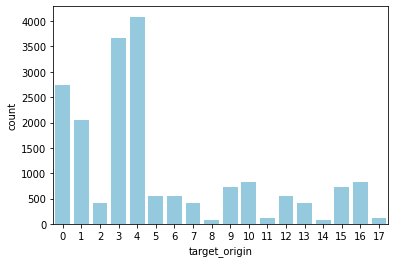

In [27]:
sns.countplot(x="target_origin",
              data=preprocessed_train,
              color="skyblue")
plt.show()

* $n = 6*mask + 3*gender + age$
    *  8 = 102 = `마스크 잘못씀, 여자, 60세이상`
    * 11 = 112 = `마스크 잘못씀, 남자, 60세이상`
    * 14 = 202 = `마스크 미착용, 여자, 60세이상`
    * 17 = 212 = `마스크 미착용, 남자, 60세이상`

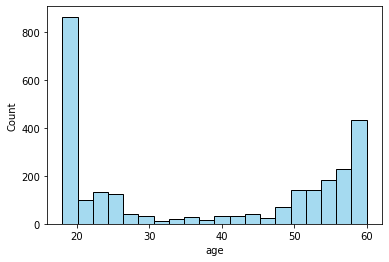

In [78]:
sns.histplot(x="age",
             data=raw_train_data,
             bins=20,
             color="skyblue"
            )
plt.show()

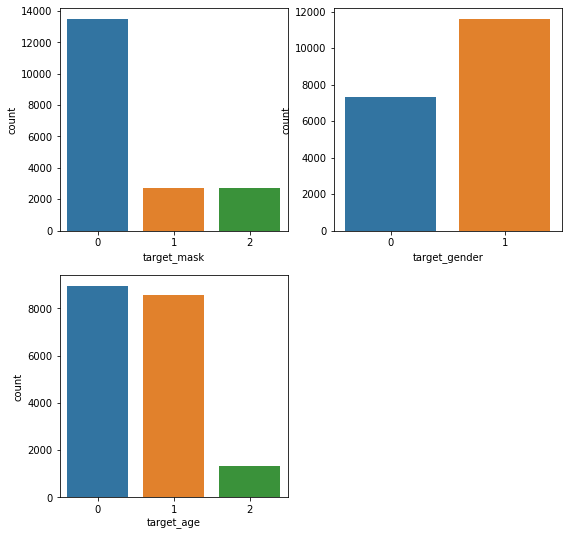

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes = axes.flatten()

sns.countplot(x="target_mask",
              data=preprocessed_train,  
#               color="skyblue",
              ax=axes[0]
             )
sns.countplot(x="target_gender",
              data=preprocessed_train,
#               color="skyblue",
              ax=axes[1]
             )
sns.countplot(x="target_age",
              data=preprocessed_train,
#               color="skyblue",
              ax=axes[2]
             )
axes[3].set_visible(False)

plt.show()

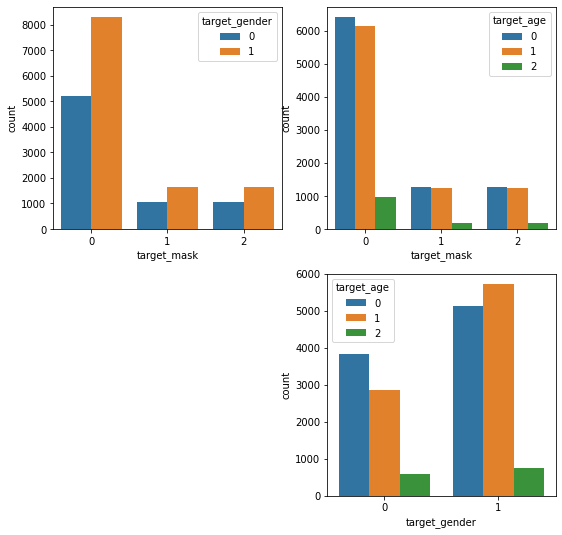

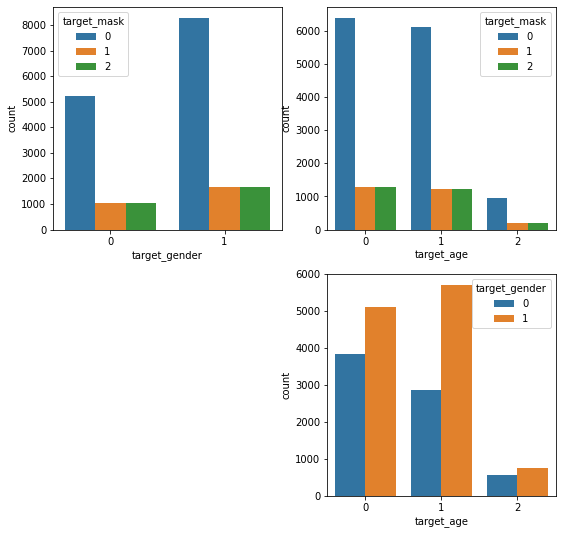

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes = axes.flatten()

sns.countplot(x="target_mask", # 0 : wear, 1 : incorrect, 2 : normal
              data=preprocessed_train,
              # 0 : male, 1 : female
              hue="target_gender", 
              ax=axes[0]
             )
sns.countplot(x="target_mask",
              data=preprocessed_train,
              # 0 : 30 미만, 1 : 30 이상 60 미만, 2 : 60 이상
              hue="target_age", 
              ax=axes[1]
             )
axes[2].set_visible(False)
sns.countplot(x="target_gender", # 0 : wear, 1 : incorrect, 2 : normal
              data=preprocessed_train,
              # 0 : 30 미만, 1 : 30 이상 60 미만, 2 : 60 이상
              hue = "target_age",
              ax=axes[3]
             )

plt.show()

# -----------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes = axes.flatten()

sns.countplot(x="target_gender", # 0 : wear, 1 : incorrect, 2 : normal
              data=preprocessed_train,
              # 0 : male, 1 : female
              hue="target_mask", 
              ax=axes[0]
             )
sns.countplot(x="target_age",
              data=preprocessed_train,
              # 0 : 30 미만, 1 : 30 이상 60 미만, 2 : 60 이상
              hue="target_mask", 
              ax=axes[1]
             )
axes[2].set_visible(False)
sns.countplot(x="target_age",
              # 0 : male, 1 : female
              data=preprocessed_train,
              hue = "target_gender",
              ax=axes[3]
             )

plt.show()



## 2.2. path에 저장된 이미지는 어떻게 생겼나 .. ?

In [7]:
def is_not_hidden_file(file_name):
    return file_name[0] != "."

def draw_imgs_for_a_sample():
    # 1. 데이터 1개만 샘플링해서 이미지가 있는 path를 지정
    img_dir_path = raw_train_data.sample(1)["path"].iloc[0]
    print(img_dir_path)
    img_dir_path = TRAIN_IMG_ROOT + img_dir_path
    
    # 2. 지정된 path에 접근해서 img를 리스트에 넣음
    img_paths = []

    for img_file_name in os.listdir(img_dir_path):
        if is_not_hidden_file(img_file_name):
#             print(img_file_name)
            img_paths.append(os.path.join(img_dir_path, img_file_name))
    
    imgs = []

    for img_path in img_paths:
        imgs.append(Image.open(img_path))
    
    # 3. 각 img에 대해서 그림을 그린다.
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16, 12))

    axes_flatten = axes.flatten()
    for position, img in enumerate(imgs, start=0):
        axes_flatten[position].imshow(X=img)
        axes_flatten[position].set_xticks([])
        axes_flatten[position].set_yticks([])

    for position in range(position + 1, 9):
        try:
            axes_flatten[position].set_visible(False)
        except:
            pass

    plt.show()

005269_male_Asian_21


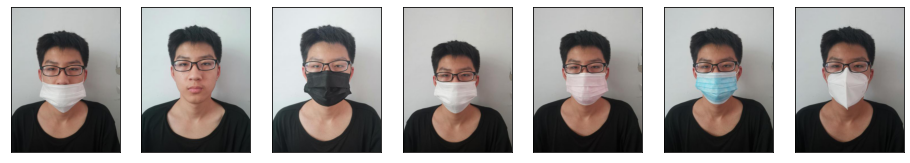

004391_female_Asian_55


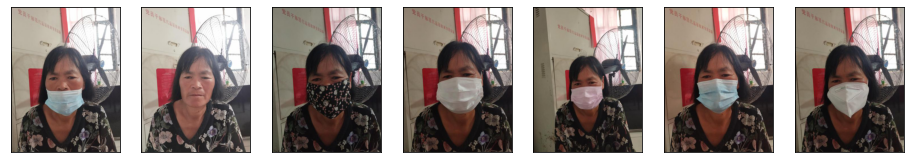

004480_female_Asian_58


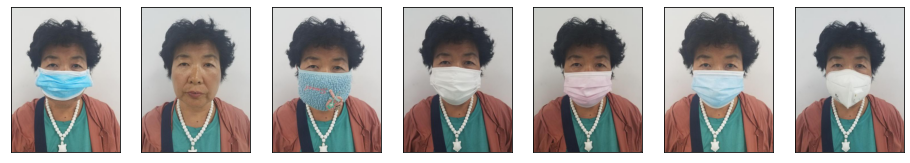

001192_male_Asian_23


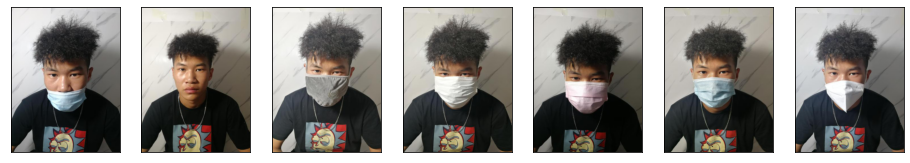

001486_female_Asian_60


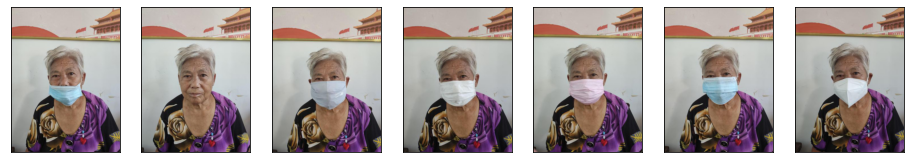

001388_male_Asian_21


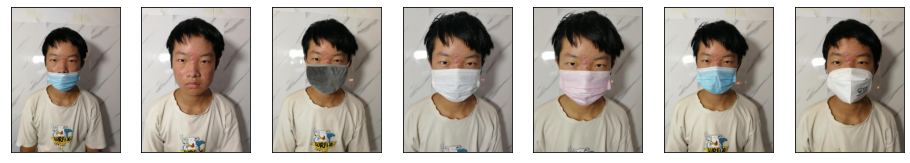

003528_male_Asian_60


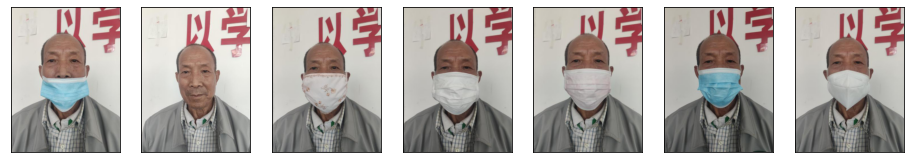

005245_male_Asian_20


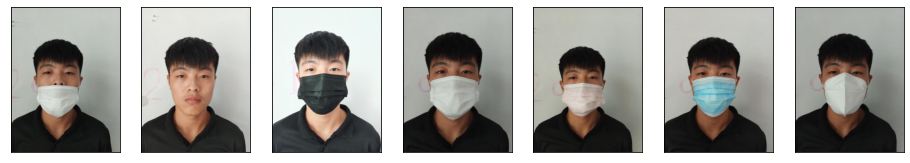

003044_female_Asian_20


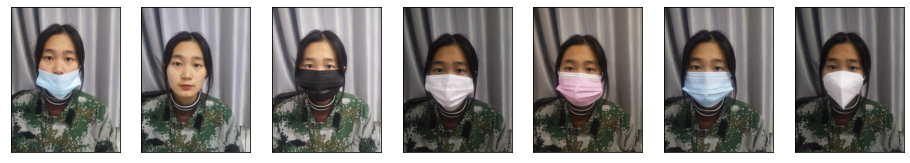

001563_female_Asian_55


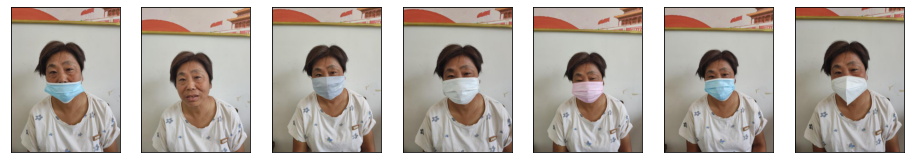

In [8]:
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()
draw_imgs_for_a_sample()

---

In [9]:
class TrainDataset_w_1_feature(Dataset):
    def __init__(self, train_csv_path, transform=None):
        self.train_csv_path = train_csv_path
        self.transform = transform
        train_data = self.__set_target_mask_of_train(train_csv_path)
        self.img_paths = train_data["img_path"].to_numpy()
        self.y = train_data["target_origin"].to_numpy()
        
    def __getitem__(self, index):
        if self.transform is not None:
            result = (self.transform(Image.open(self.img_paths[index])), self.y[index])
        else:
            result = (self.img_paths[index], self.y[index])
        return result
    
    def __len__(self):
        return len(self.y)
    
    def __is_not_hidden_file(self, file_name):
        return file_name[0] != "."

    def __set_target_mask_of_train(self, train_csv_path):
        def cvt_age(age):
            if age < 30:
                return 0 # < 30
            elif age < 60:
                return 1 # 30 <= age < 60
            else:
                return 2 # >= 60

        def cvt_gender(gender):
            if gender.upper() == "MALE":
                return 0 # male
            else:
                return 1 # female
        
        train_img_dir = os.path.join(train_dir, "images") # train_dir : global
        
        raw_train_data = pd.read_csv(train_csv_path)
        returned_train = pd.DataFrame()
        raw_train_data2np_array = np.array(raw_train_data)

        idxes = []
        genders = []
        ages = []
        target_masks = []
        img_paths = []

        for idx, gender, _, age, path in raw_train_data2np_array:
            # 1. 데이터 1개에 대해 이미지가 있는 path를 지정
            img_dir_path = os.path.join(train_img_dir, path)

            for img_file_name in os.listdir(img_dir_path):
                if self.__is_not_hidden_file(img_file_name):
                    if "incorrect" in img_file_name:
                        target_masks.append(1)
                    elif "mask" in img_file_name:
                        target_masks.append(0)
                    elif "normal" in img_file_name:
                        target_masks.append(2)

                    idxes.append(idx)
                    genders.append(gender)
                    ages.append(age)

                    img_path = os.path.join(img_dir_path, img_file_name)
                    img_paths.append(img_path)

        returned_train = pd.DataFrame([idxes, genders, ages, img_paths, target_masks]).T
        returned_train.columns = ["id", "gender", "age", "img_path", "target_mask"]

        returned_train["target_gender"] = returned_train["gender"].apply(cvt_gender)
        returned_train["target_age"] = returned_train["age"].apply(cvt_age)
        returned_train.drop(["age", "gender"], axis=1, inplace=True)

        returned_train["target_origin"] = 6 * returned_train["target_mask"] + 3 * returned_train["target_gender"] +  returned_train["target_age"]

        return returned_train

In [10]:
# idx = 100

# plt.imshow(transform_normal(imgs[idx]))
# plt.show()

# plt.imshow(transform_rotate(imgs[idx]))
# plt.show()

# plt.imshow(transform_crop(imgs[idx]))
# plt.show()

## 2.3. labeling 이 잘못된 이미지?

In [45]:
def is_not_hidden_file(file_name):
    return file_name[0] != "."

def draw_imgs_for_a_person(img_dir_path):
    # 1. 데이터 1개만 샘플링해서 이미지가 있는 path를 지정
#     img_dir_path = raw_train_data.sample(1)["path"].iloc[0]
#     print(img_dir_path)
    img_dir_path = os.path.join(TRAIN_IMG_ROOT, img_dir_path)
    
    # 2. 지정된 path에 접근해서 img를 리스트에 넣음
    img_paths = []

    for img_file_name in os.listdir(img_dir_path):
        if is_not_hidden_file(img_file_name):
#             print(img_file_name)
            img_paths.append(os.path.join(img_dir_path, img_file_name))
    
#     imgs = []

#     for img_path in img_paths:
#         imgs.append(Image.open(img_path))
    
    # 3. 각 img에 대해서 그림을 그린다.
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16, 3))

    axes_flatten = axes.flatten()
    fig.suptitle(img_dir_path.split("/")[-1])
    for position, img_path in enumerate(img_paths, start=0):
        axes_flatten[position].set_title(img_path.split("/")[-1])
        axes_flatten[position].imshow(X=Image.open(img_path))
        axes_flatten[position].set_xticks([])
        axes_flatten[position].set_yticks([])

    for position in range(position + 1, 9):
        try:
            axes_flatten[position].set_visible(False)
        except:
            pass

    plt.show()

In [ ]:
df_male = raw_train_data[
    raw_train_data["gender"] == "male"
]

df_female = raw_train_data[
    raw_train_data["gender"] == "female"
]

---

# ALL Image 
* 셀에 출력하지 말고 저장을 해서 빼내자

In [25]:
# for img_dir_path in np.array(df_male["path"]):
#     draw_imgs_for_a_person(img_dir_path)

In [26]:
# for img_dir_path in np.array(df_female["path"]):
#     draw_imgs_for_a_person(img_dir_path)

---

---

# 3. EDA 시도

## 3.1. 남자, 여자 중 더 많은 쪽은?

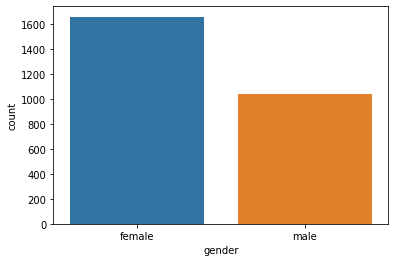

In [105]:
sns.countplot(x="gender", data=raw_train_data)
plt.show()

* 여자가 더 많다! $\rightarrow$ Data augmentation!

# 3.2. 나이대 별 분포도 살펴보자!

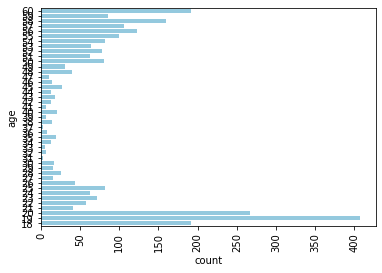

In [106]:
order = np.sort(raw_train_data["age"].unique())[::-1]
sns.countplot(y="age", 
              data=raw_train_data, 
              color="skyblue",
              order=order)
plt.xticks(rotation=90)
plt.show()

 - null data 의 개수 : 0


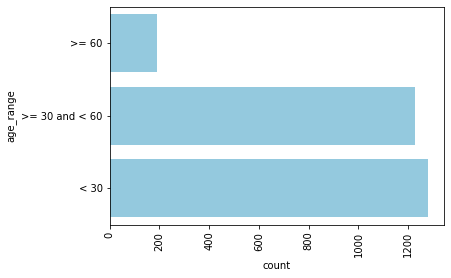

In [107]:
def age_range(age):
    result = ""
    if age < 30:
        result = " < 30"
    elif age < 60:
        result = ">= 30 and < 60"
    else:
        result = ">= 60"
    return result

raw_train_data["age_range"] = raw_train_data["age"].apply(age_range)
num_of_na_in_age_range = raw_train_data["age_range"].isna().sum()
print(f" - null data 의 개수 : {num_of_na_in_age_range}")

order = np.sort(raw_train_data["age_range"].unique())[::-1]
sns.countplot(y="age_range", 
              data=raw_train_data, 
              color="skyblue",
              order=order)
plt.xticks(rotation=90)
plt.show()

## 3.3. input이 될 X에 대한 분석

In [108]:
imgs = get_all_img_paths()

### 3.3.1. Image size

In [109]:
first_img = imgs[0]
print(f"(#rows, #cols, #channels) = {np.array(first_img).shape}")

(#rows, #cols, #channels) = (512, 384, 3)


### 3.3.2. 분석 대상이 되는 객체의 위치

In [110]:
# 머리카락, 얼굴, 마스크를 포함하는 부분 (주로 사진 정중앙)

### 3.3.3. RGB 채널별 통계 값

In [111]:
# img_np_arrays = [np.array(img) for img in imgs]
# img_np_arrays = np.array(img_np_arrays)
# 미친짓인거 같다!

In [20]:
def is_not_hidden_file(file_name):
    return file_name[0] != "."

def get_all_img_paths():
    # 1. 데이터 1개만 샘플링해서 이미지가 있는 path를 지정
    img_dir_paths = raw_train_data["path"]
    img_dir_paths = TRAIN_IMG_ROOT + img_dir_paths

    # 2. 지정된 path에 접근해서 img를 리스트에 넣음
    img_paths = []

    for img_dir_path in img_dir_paths:
        for img_file_name in os.listdir(img_dir_path):
            if is_not_hidden_file(img_file_name):
                img_paths.append(os.path.join(img_dir_path, img_file_name))

#     print(f"트레이닝 이미지의 개수 : {len(img_paths)}장")
    
    imgs = []
    for img_path in img_paths:
        imgs.append(Image.open(img_path))
        
    return imgs
imgs = get_all_img_paths()

In [119]:
first_img = imgs[np.random.randint(0, raw_train_data.shape[0] * 7)]
first_img2np_array = np.array(first_img)

In [120]:
first_img2np_array_R = first_img2np_array[:, :, 0].flatten()
first_img2np_array_G = first_img2np_array[:, :, 1].flatten()
first_img2np_array_B = first_img2np_array[:, :, 2].flatten()

In [121]:
df_RGB = pd.DataFrame([first_img2np_array_R, first_img2np_array_G, first_img2np_array_B])
df_RGB = df_RGB.T
df_RGB.columns = ["R channel", "G channel", "B channel"]

In [122]:
df_RGB.head()

,R channel,G channel,B channel
0,163,163,155
1,158,158,150
2,159,159,151
3,166,166,158
4,170,170,162


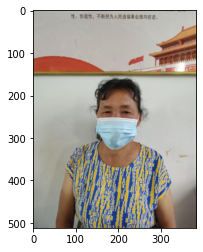

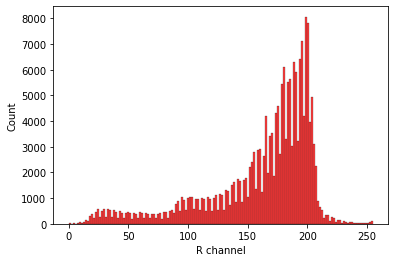

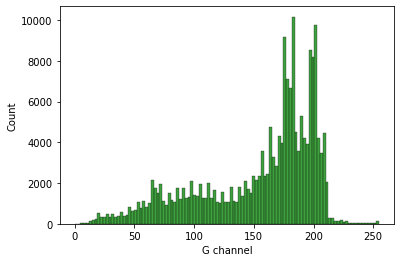

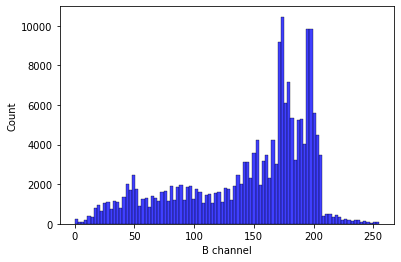

In [123]:
plt.imshow(first_img)
plt.show()

sns.histplot(data=df_RGB,
              x="R channel",
              color="red")
plt.show()

sns.histplot(data=df_RGB,
              x="G channel",
              color="green")
plt.show()

sns.histplot(data=df_RGB,
              x="B channel",
              color="blue")
plt.show()

# del first_img, first_img2np_array
# del df_RGB, first_img2np_array_R, first_img2np_array_G, first_img2np_array_B

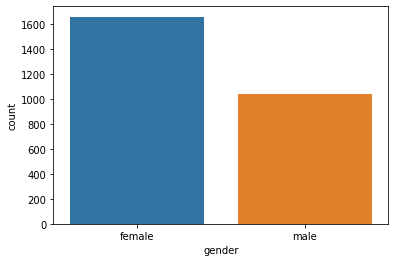

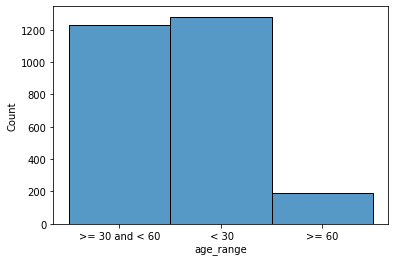

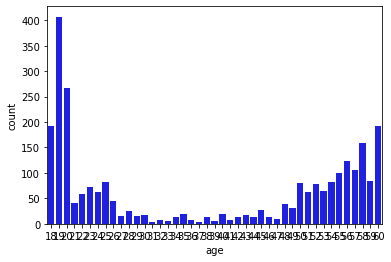

In [152]:
# fig, axes = plt.subplots(nrows=1, ncols=3)
# sns.FacetGrid(data=raw_train_data, aspect=1, height=10)
# axes[0].set_visible(True)
sns.countplot(x="gender",
              data=raw_train_data)
plt.show()
# axes[1].set_visible(True)

def set_color_by(age):
    if age < 30:
        return "red"
    elif age < 60:
        return "blue"
    else:
        return "green"

# color_by_age_range = pd.Series(np.sort(raw_train_data["age"].unique())).apply(set_color_by).to_numpy()
    
sns.histplot(x="age_range",
              data=raw_train_data,
              order=sorted(raw_train_data["age_range"].unique()),
              bins=3)
plt.show()

# sns.histplot(x="age",
#               data=raw_train_data,
#               bins=len(raw_train_data["age"].unique()))
sns.countplot(x="age",
              data=raw_train_data,
              color="blue")
# plt.xticks(np.sort(raw_train_data["age"].unique()))
# plt.plot([30 for _ in range(500)], np.arange(0, 500, 1), linestyle="--", color="orange")
# plt.plot([60 for _ in range(500)], np.arange(0, 500, 1), linestyle="--", color="red")

# plt.plot(x=30, y=np.arange(0, 500, 0.1), linestyle="--")
plt.show()

## 3.4. Target y에 대한 분석

### 3.4.1. y값의 독립적인 분포 확인